# Análise do PIB de países com Graph Neural Networks (GNN) Classification

In [68]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx


import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import KBinsDiscretizer
import plotly.express as px


import seaborn as sns


O objetivo do presente trabalho é prever o PIB (ou GDP) per capita de países com base em uma rede, considerando tanto as informações de determinado país quanto as de seus vizinhos. Para isso, faremos uma regressão e utilizaremos a ferramenta GNN - Graph Neural Network.

## Preparando os dados

### Carregando o dataset com os países vizinhos

Dataset que contém as fronteiras de cada país:

In [69]:
json_file_path = "nodes_and_links_countries.json"

with open(json_file_path, 'r') as j:
     jdict = json.loads(j.read())

### Carregando o dataset com os dados dos países

Dataset que contém as informações de cada país:

In [70]:
path = "countries of the world.csv"
df_gdp = pd.read_csv(path,decimal=',')
df_gdp.head().T

,0,1,2,3,4
Country,Afghanistan,Albania,Algeria,American Samoa,Andorra
Region,ASIA (EX. NEAR EAST),EASTERN EUROPE,NORTHERN AFRICA,OCEANIA,WESTERN EUROPE
Population,31056997,3581655,32930091,57794,71201
Area (sq. mi.),647500,28748,2381740,199,468
Pop. Density (per sq. mi.),48,124.6,13.8,290.4,152.1
Coastline (coast/area ratio),0,1.26,0.04,58.29,0
Net migration,23.06,-4.93,-0.39,-20.71,6.6
Infant mortality (per 1000 births),163.07,21.52,31,9.27,4.05
GDP ($ per capita),700,4500,6000,8000,19000
Literacy (%),36,86.5,70,97,100


In [71]:
### Removendo espaços ao final do nome dos países
df_gdp['Country'] = df_gdp['Country'].map(lambda x: str(x)[:-1])

### Alterando nomes de países para combinar os datasets

In [72]:
correspondence = {
   'Micronesia, Fed. St.':'Federated States of Micronesia',
   'Antigua & Barbuda':'Antigua and Barbuda',
   'Bahamas, The':'Bahamas',
   'Saint Kitts & Nevis': 'Saint Kitts and Nevis',
   'Trinidad & Tobago':'Trinidad and Tobago',
   'Central African Rep.': 'Central African Republic',
   'Congo, Dem. Rep.':'Democratic Republic of the Congo',
   'Congo, Repub. of the':'Republic of the Congo',
   "Cote d'Ivoire": "Côte d'Ivoire",
   'Gambia, The': 'The Gambia',
   'Sao Tome & Principe':'São Tomé and Príncipe',
   'Bosnia & Herzegovina': 'Bosnia and Herzegovina',
   'Macedonia':'North Macedonia',
   'China': "People's Republic of China",
   'Korea, North':'North Korea',
   'Korea, South':'South Korea',
   'Burma':'Myanmar'
    }

In [73]:
df_gdp = df_gdp.replace({"Country": correspondence})

In [74]:
countries_df = df_gdp['Country'].values
countries_nodes = ([node['name'] for node in jdict['nodes']])

mismatch = [i for i in countries_nodes if i not in countries_df]

print(
"countries_df: ",len(countries_df),
"countries_nodes: ",len(countries_nodes),
"mismatch: ",len(mismatch),
"mismatch countries:", mismatch
)

countries_df:  227 countries_nodes:  195 mismatch:  4 mismatch countries: ['South Sudan', 'Montenegro', 'Vatican City', 'Palestine']


Parece que alguns países não têm correspondência. Como são bem poucos, podemos removê-los:

In [75]:
nodes = set(countries_nodes)-set(mismatch)
len(nodes)

191

### Dataset com países correspondentes

Vamos deixar somente os países com correspondência nos dois datasets para a análise:

In [76]:
nodes_df = [i for i in nodes]
df = df_gdp[df_gdp['Country'].isin(nodes_df)]
df.head(5).T

,0,1,2,4,5
Country,Afghanistan,Albania,Algeria,Andorra,Angola
Region,ASIA (EX. NEAR EAST),EASTERN EUROPE,NORTHERN AFRICA,WESTERN EUROPE,SUB-SAHARAN AFRICA
Population,31056997,3581655,32930091,71201,12127071
Area (sq. mi.),647500,28748,2381740,468,1246700
Pop. Density (per sq. mi.),48,124.6,13.8,152.1,9.7
Coastline (coast/area ratio),0,1.26,0.04,0,0.13
Net migration,23.06,-4.93,-0.39,6.6,0
Infant mortality (per 1000 births),163.07,21.52,31,4.05,191.19
GDP ($ per capita),700,4500,6000,19000,1900
Literacy (%),36,86.5,70,100,42


#### Tirando algumas colunas que não serão utilizadas na análise inicial

In [77]:
df.drop(['Region','Climate'], axis=1, inplace=True)
df.head(5).T

c:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,0,1,2,4,5
Country,Afghanistan,Albania,Algeria,Andorra,Angola
Population,31056997,3581655,32930091,71201,12127071
Area (sq. mi.),647500,28748,2381740,468,1246700
Pop. Density (per sq. mi.),48,124.6,13.8,152.1,9.7
Coastline (coast/area ratio),0,1.26,0.04,0,0.13
Net migration,23.06,-4.93,-0.39,6.6,0
Infant mortality (per 1000 births),163.07,21.52,31,4.05,191.19
GDP ($ per capita),700,4500,6000,19000,1900
Literacy (%),36,86.5,70,100,42
Phones (per 1000),3.2,71.2,78.1,497.2,7.8


In [78]:
df.isna().sum()

Country                               0
Population                            0
Area (sq. mi.)                        0
Pop. Density (per sq. mi.)            0
Coastline (coast/area ratio)          0
Net migration                         0
Infant mortality (per 1000 births)    0
GDP ($ per capita)                    0
Literacy (%)                          7
Phones (per 1000)                     2
Arable (%)                            0
Crops (%)                             0
Other (%)                             0
Birthrate                             1
Deathrate                             1
Agriculture                           3
Industry                              4
Service                               4
dtype: int64

In [79]:
df=df.dropna()   

## Análise exploratória

### Analisando correlações

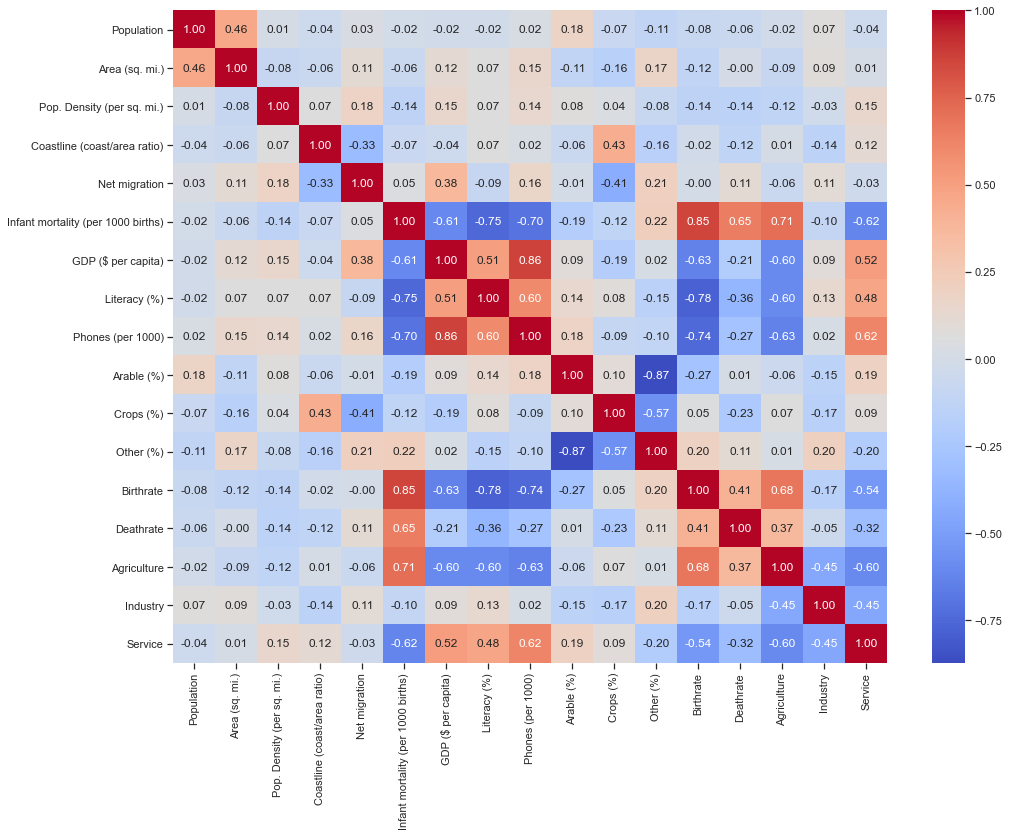

In [80]:
import seaborn as sns

plt.figure(figsize=(16,12))
sns.heatmap(data=df.iloc[:,1:].corr(),annot=True,fmt='.2f',cmap='coolwarm')
plt.show()

c:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\User\anaconda3\l

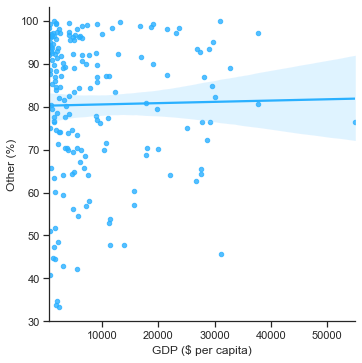

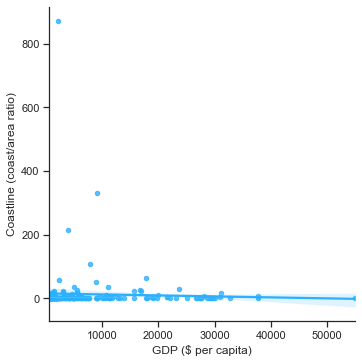

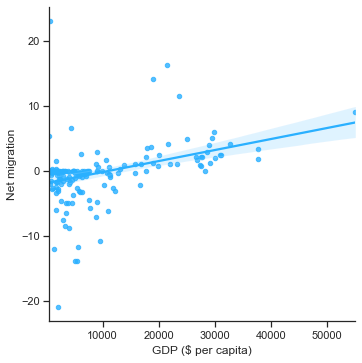

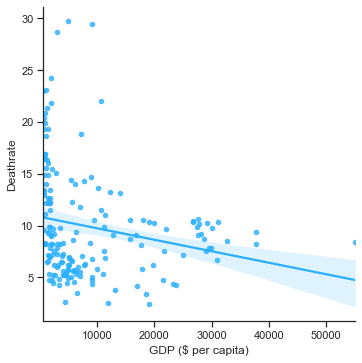

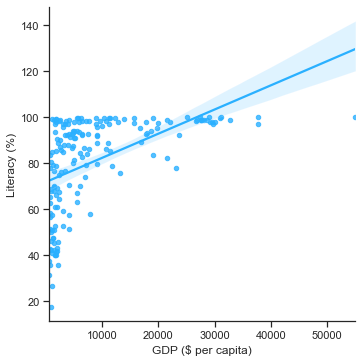

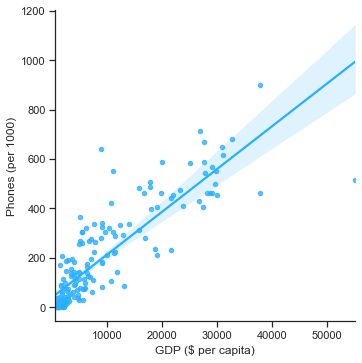

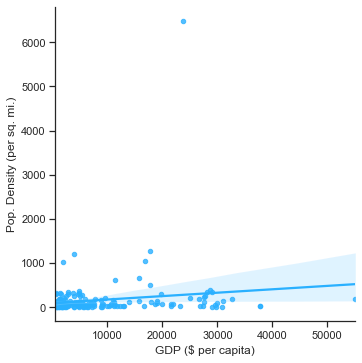

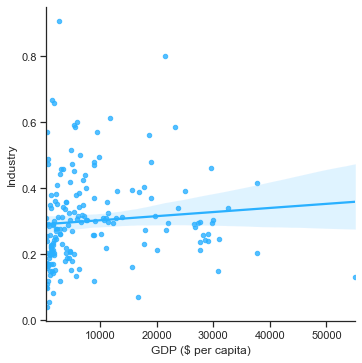

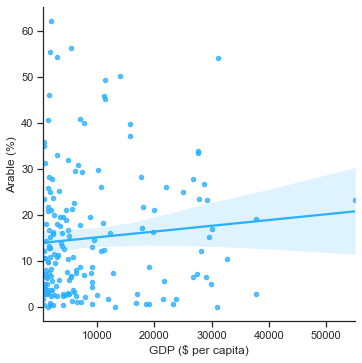

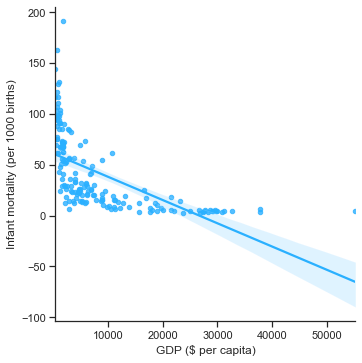

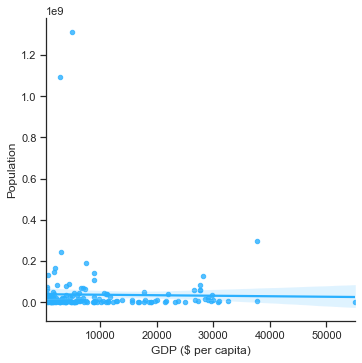

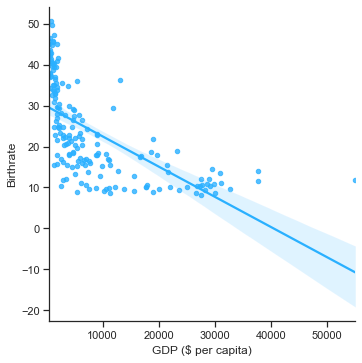

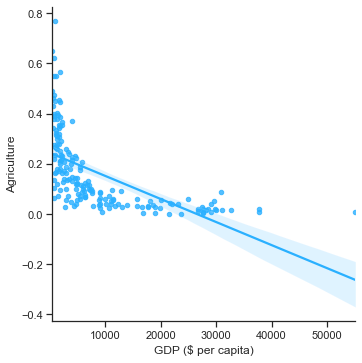

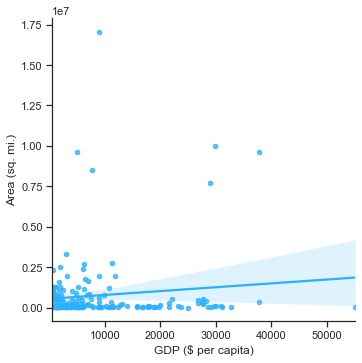

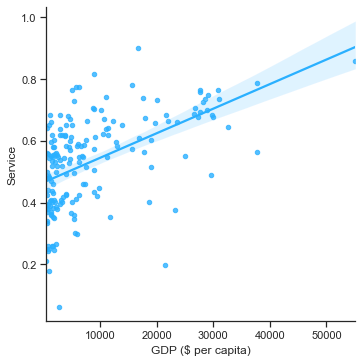

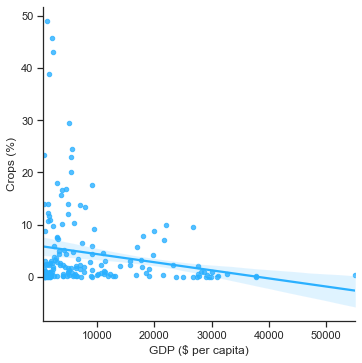

In [81]:
p=['#2ab0ff', 'pink', 'green','purple', 'r', 'b', 'y']
sns.set_theme(style="ticks", palette=p, font_scale=1)

num = set(df.columns.to_list()) - {'Country', 'GDP ($ per capita)', 'Climate'}

for n in num:
    sns.lmplot('GDP ($ per capita)', n, data=df, fit_reg=True, scatter_kws={"marker": "D", "s": 20})

### Distribuição dos dados

array([[<AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'Area (sq. mi.)'}>,
        <AxesSubplot:title={'center':'Pop. Density (per sq. mi.)'}>,
        <AxesSubplot:title={'center':'Coastline (coast/area ratio)'}>],
       [<AxesSubplot:title={'center':'Net migration'}>,
        <AxesSubplot:title={'center':'Infant mortality (per 1000 births)'}>,
        <AxesSubplot:title={'center':'GDP ($ per capita)'}>,
        <AxesSubplot:title={'center':'Literacy (%)'}>],
       [<AxesSubplot:title={'center':'Phones (per 1000)'}>,
        <AxesSubplot:title={'center':'Arable (%)'}>,
        <AxesSubplot:title={'center':'Crops (%)'}>,
        <AxesSubplot:title={'center':'Other (%)'}>],
       [<AxesSubplot:title={'center':'Birthrate'}>,
        <AxesSubplot:title={'center':'Deathrate'}>,
        <AxesSubplot:title={'center':'Agriculture'}>,
        <AxesSubplot:title={'center':'Industry'}>],
       [<AxesSubplot:title={'center':'Service'}>, <AxesSubplot:>,
     

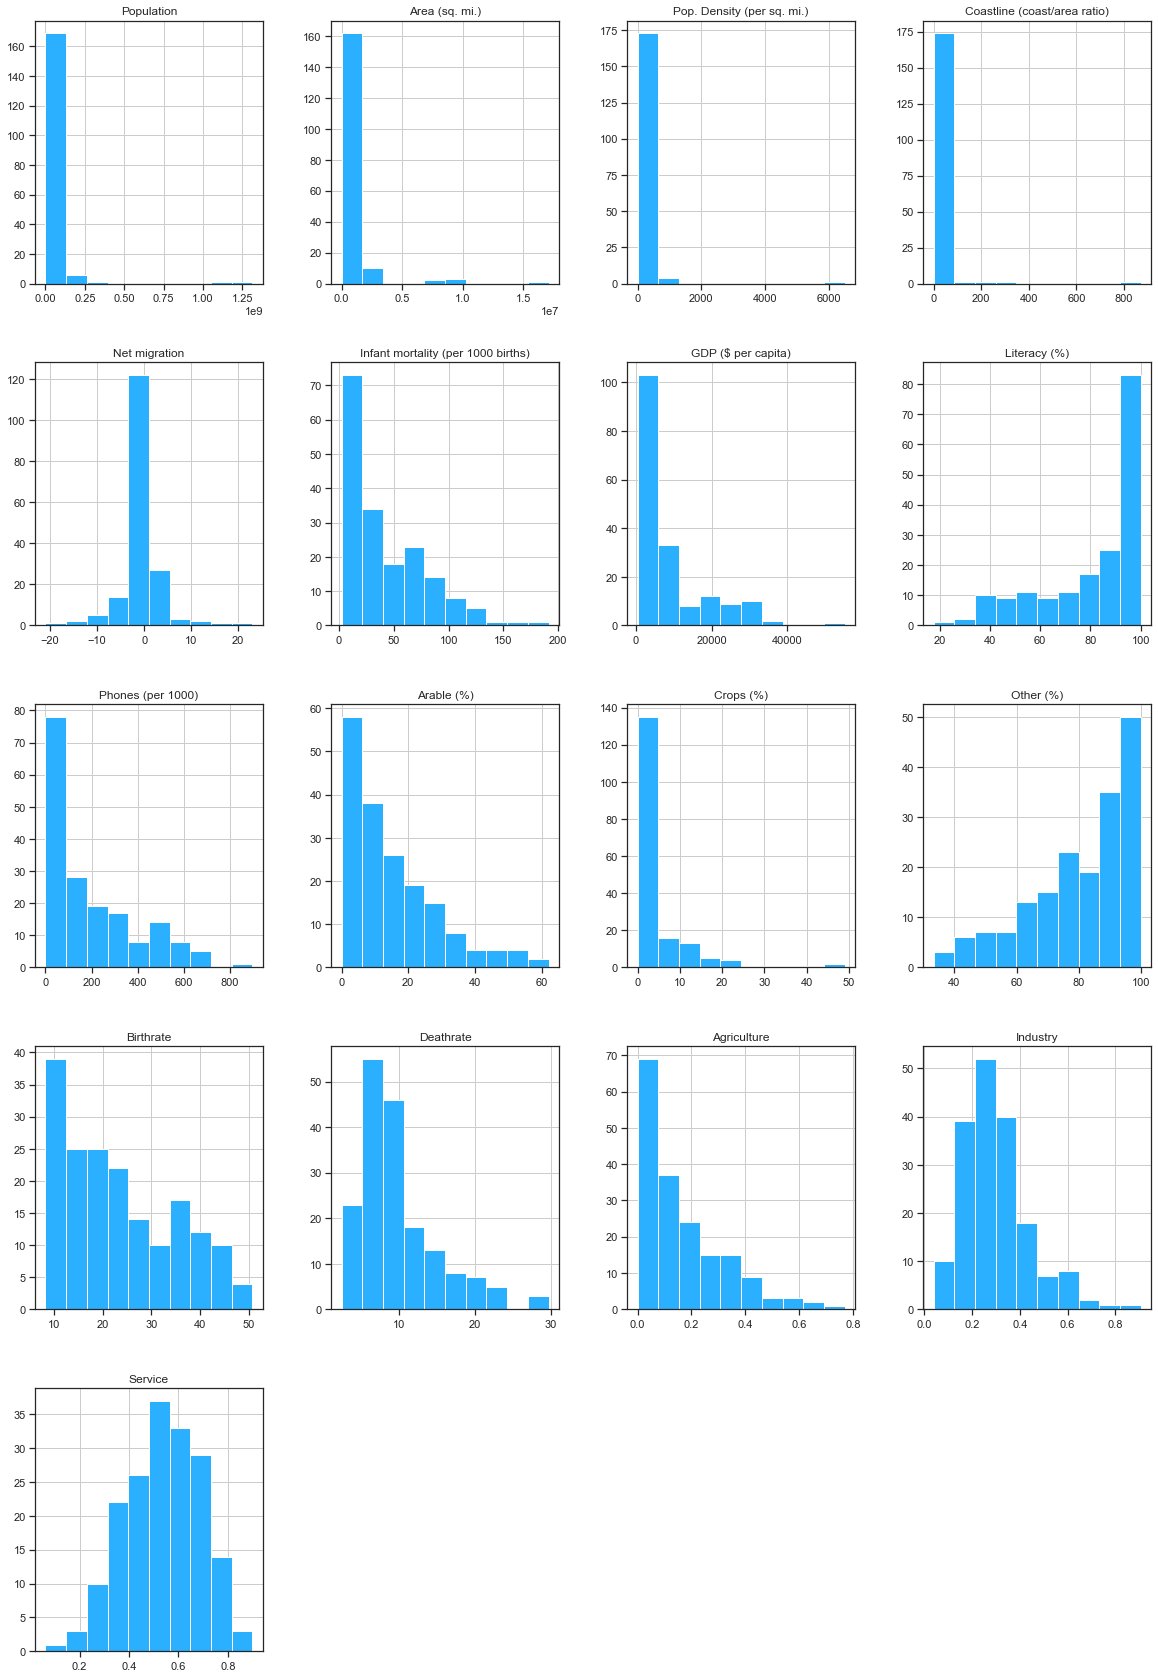

In [82]:
df.hist(figsize=(20,30))

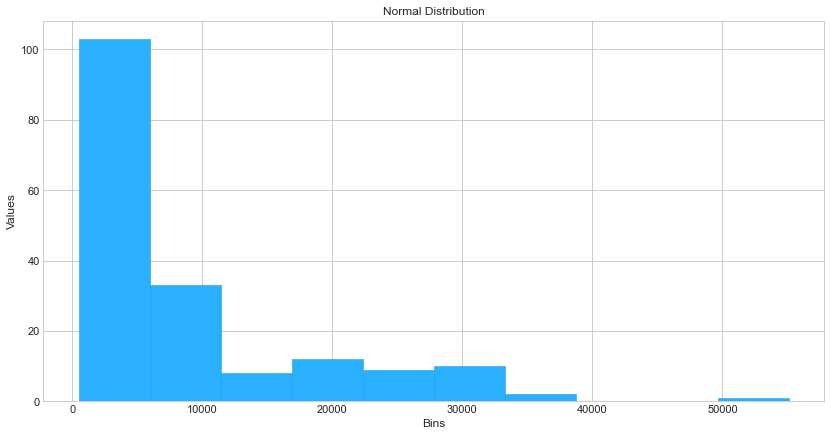

In [83]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(df["GDP ($ per capita)"], facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Normal Distribution') 
plt.xlabel('Bins') 
plt.ylabel('Values') 
plt.show()

<AxesSubplot:xlabel='GDP ($ per capita)'>

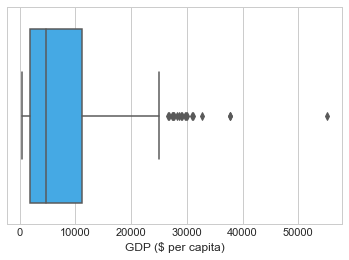

In [84]:
sns.boxplot(data = df, x = "GDP ($ per capita)")

Parece que existe forte assimetria em algumas colunas do dataset. Isso inclui o target, que tem uma forte assimetria a direita, com muitos outliers.
Para casos de assimetria a direita, vamos aplicar log na base 10. Para casos de assimetria a direita, vamos aplicar raiz quadrada.

In [85]:
df_filtered = df.copy()
df_filtered['Infant mortality (per 1000 births)'] = df['Infant mortality (per 1000 births)'].apply(np.log10)
df_filtered['GDP ($ per capita)'] = df['GDP ($ per capita)'].apply(np.log10)
df_filtered['Phones (per 1000)'] = df['Phones (per 1000)'].apply(np.log10)
df_filtered['Population'] = df['Population'].apply(np.log10)
df_filtered['Area (sq. mi.)'] = df['Area (sq. mi.)'].apply(np.log10)
# df_filtered['Agriculture'] = df['Agriculture'].apply(np.log10)
df_filtered['Deathrate'] = df['Deathrate'].apply(np.log10)

# df_filtered['Arable (%)'] = df['Arable (%)'].apply(np.log10)
# df_filtered['Crops (%)'] = df['Crops (%)'].apply(np.log10)
# df_filtered['Coastline (coast/area ratio)'] = df['Coastline (coast/area ratio)'].apply(np.log10)
df_filtered['Pop. Density (per sq. mi.)'] = df['Pop. Density (per sq. mi.)'].apply(np.log10)
df_filtered['Other (%)'] = df['Other (%)'].apply(np.sqrt)
df_filtered['Literacy (%)'] = df['Literacy (%)'].apply(np.sqrt)


array([[<AxesSubplot:title={'center':'Population'}>,
        <AxesSubplot:title={'center':'Area (sq. mi.)'}>,
        <AxesSubplot:title={'center':'Pop. Density (per sq. mi.)'}>,
        <AxesSubplot:title={'center':'Coastline (coast/area ratio)'}>],
       [<AxesSubplot:title={'center':'Net migration'}>,
        <AxesSubplot:title={'center':'Infant mortality (per 1000 births)'}>,
        <AxesSubplot:title={'center':'GDP ($ per capita)'}>,
        <AxesSubplot:title={'center':'Literacy (%)'}>],
       [<AxesSubplot:title={'center':'Phones (per 1000)'}>,
        <AxesSubplot:title={'center':'Arable (%)'}>,
        <AxesSubplot:title={'center':'Crops (%)'}>,
        <AxesSubplot:title={'center':'Other (%)'}>],
       [<AxesSubplot:title={'center':'Birthrate'}>,
        <AxesSubplot:title={'center':'Deathrate'}>,
        <AxesSubplot:title={'center':'Agriculture'}>,
        <AxesSubplot:title={'center':'Industry'}>],
       [<AxesSubplot:title={'center':'Service'}>, <AxesSubplot:>,
     

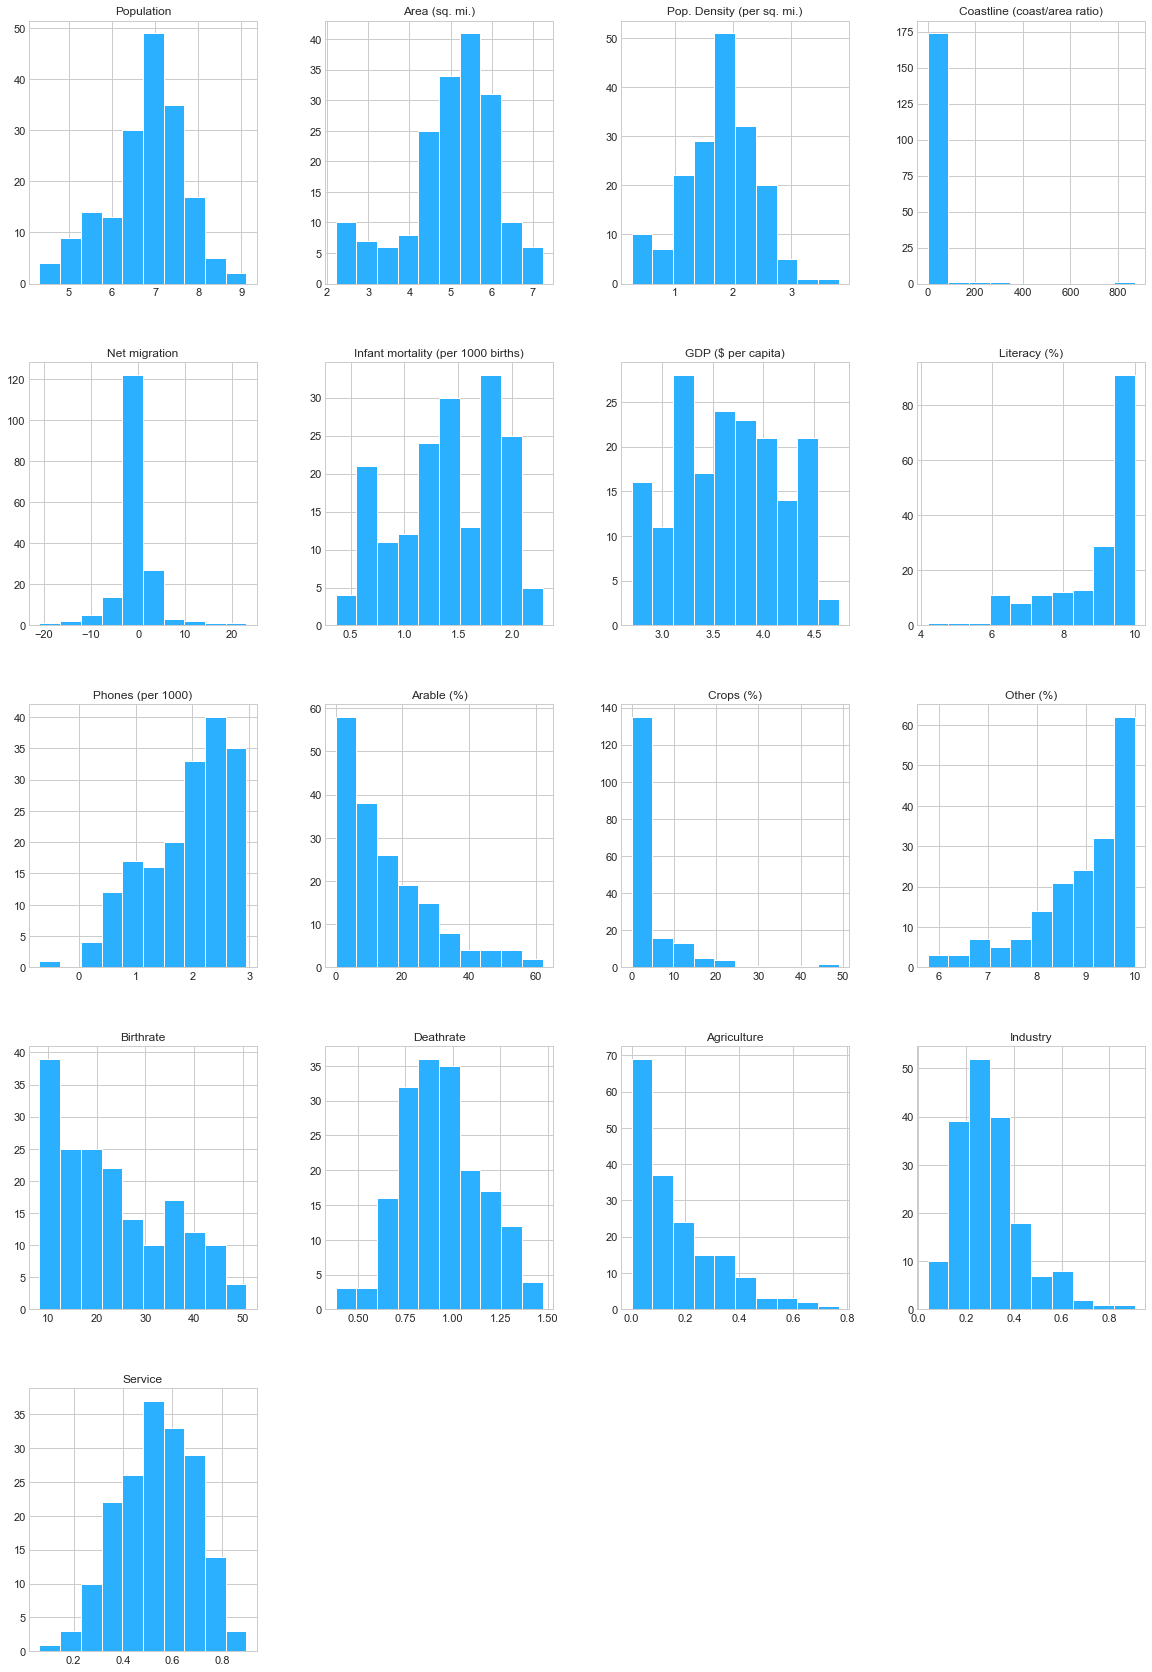

In [86]:
df_filtered.hist(figsize=(20,30))

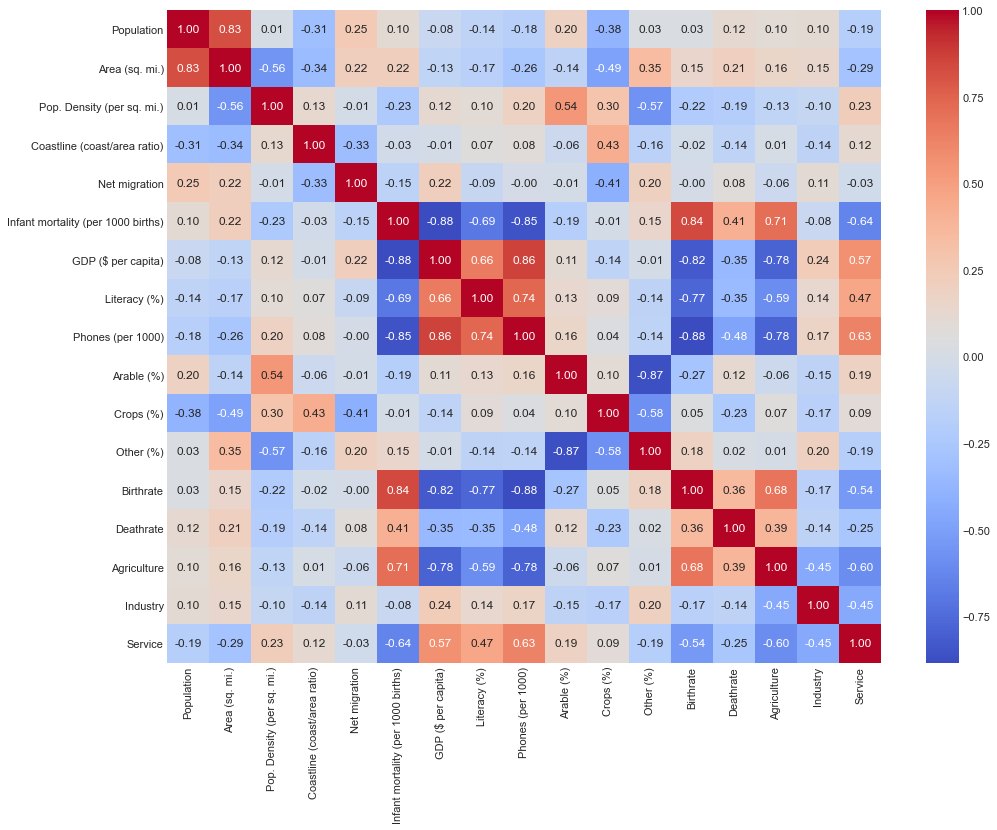

In [87]:
import seaborn as sns

plt.figure(figsize=(16,12))
sns.heatmap(data=df_filtered.iloc[:,1:].corr(),annot=True,fmt='.2f',cmap='coolwarm')
plt.show()

Parece que a distribuição do target melhorou bem depois que o log foi aplicado.

<AxesSubplot:xlabel='GDP ($ per capita)'>

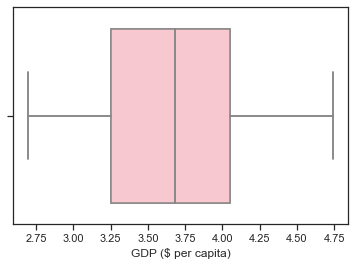

In [88]:
p=['pink', 'blue']
sns.set_theme(style="ticks", palette=p, font_scale=1)

sns.boxplot(data = df_filtered, x = "GDP ($ per capita)")
sns.boxplot(x=df_filtered["GDP ($ per capita)"])

## Montagem do grafo

### Criando identificadores únicos para os países

In [89]:
df_test = df_filtered.copy()

class_values = sorted(df_test["Country"].unique())
print(len(class_values))
class_idx = {name: id for id, name in enumerate(class_values)}
df_test["Country ID"] = df_test["Country"].apply(lambda name: class_idx[name])
df_test.head().T

178


,0,1,2,5,7
Country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda
Population,7.49216,6.55408,7.51759,7.08376,4.83953
Area (sq. mi.),5.81124,4.45861,6.37689,6.09576,2.6464
Pop. Density (per sq. mi.),1.68124,2.09552,1.13988,0.986772,2.19312
Coastline (coast/area ratio),0,1.26,0.04,0.13,34.54
Net migration,23.06,-4.93,-0.39,0,-6.15
Infant mortality (per 1000 births),2.21237,1.33284,1.49136,2.28147,1.28914
GDP ($ per capita),2.8451,3.65321,3.77815,3.27875,4.04139
Literacy (%),6,9.30054,8.3666,6.48074,9.43398
Phones (per 1000),0.50515,1.85248,1.89265,0.892095,2.74028


In [90]:
df_test = df_test.rename({'GDP ($ per capita)': 'GDP'}, axis=1) 
df_test.T

,0,1,2,5,7,8,9,11,12,13,...,213,214,215,216,217,218,219,224,225,226
Country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
Population,7.49216,6.55408,7.51759,7.08376,4.83953,7.60121,6.47369,7.30673,6.91344,6.901,...,7.78254,8.47486,6.53554,7.43628,5.31987,7.41045,7.92636,7.33155,7.06077,7.08767
Area (sq. mi.),5.81124,4.45861,6.37689,6.09576,2.6464,6.44199,4.47422,6.88575,4.92361,4.93752,...,5.38885,6.98369,5.24606,5.6507,4.08636,5.96002,5.51793,5.72261,5.87657,5.59171
Pop. Density (per sq. mi.),1.68124,2.09552,1.13988,0.986772,2.19312,1.15836,1.99957,0.414973,1.98989,1.96332,...,2.39375,1.49136,1.29003,1.78533,1.233,1.45025,2.40841,1.60853,1.18469,1.49554
Coastline (coast/area ratio),0,1.26,0.04,0.13,34.54,0.18,0,0.34,0,0,...,5.08,0.21,0.37,0,20.72,0.31,1.05,0.36,0,0
Net migration,23.06,-4.93,-0.39,0,-6.15,0.61,-6.47,3.98,2,-4.9,...,2.19,3.41,-0.32,-1.72,0,-0.04,-0.45,0,0,0
Infant mortality (per 1000 births),2.21237,1.33284,1.49136,2.28147,1.28914,1.18127,1.36698,0.671173,0.668386,1.91243,...,0.71265,0.812913,1.07737,1.85187,1.74162,1.34635,1.41414,1.78888,1.94591,1.83052
GDP,2.8451,3.65321,3.77815,3.27875,4.04139,4.04922,3.54407,4.4624,4.47712,3.53148,...,4.44248,4.57749,4.10721,3.23045,3.4624,3.68124,3.39794,2.90309,2.90309,3.27875
Literacy (%),6,9.30054,8.3666,6.48074,9.43398,9.85393,9.92975,10,9.89949,9.84886,...,9.94987,9.84886,9.89949,9.96494,7.28011,9.66437,9.50263,7.0852,8.97775,9.52365
Phones (per 1000),0.50515,1.85248,1.89265,0.892095,2.74028,2.34321,2.29159,2.75243,2.65533,2.13704,...,2.7352,2.95328,2.46449,1.79865,1.51322,2.14644,2.27346,1.57054,0.913814,1.42813


### Garantindo correspondência entre os nomes de países dos datasets

In [91]:
existing_countries = df_test.Country.to_list()

In [92]:
edges = []
for n in jdict['links']:
    if (n['source'] in existing_countries) and (n['target'] in existing_countries):
        edges.append((n['source'], n['target']))
df_edges= pd.DataFrame.from_records(edges, columns =['source', 'target'])
df_edges.head(5).T



,0,1,2,3,4
source,Afghanistan,Afghanistan,Afghanistan,Afghanistan,Afghanistan
target,People's Republic of China,Iran,Pakistan,Tajikistan,Turkmenistan


### Visualizando como um grafo

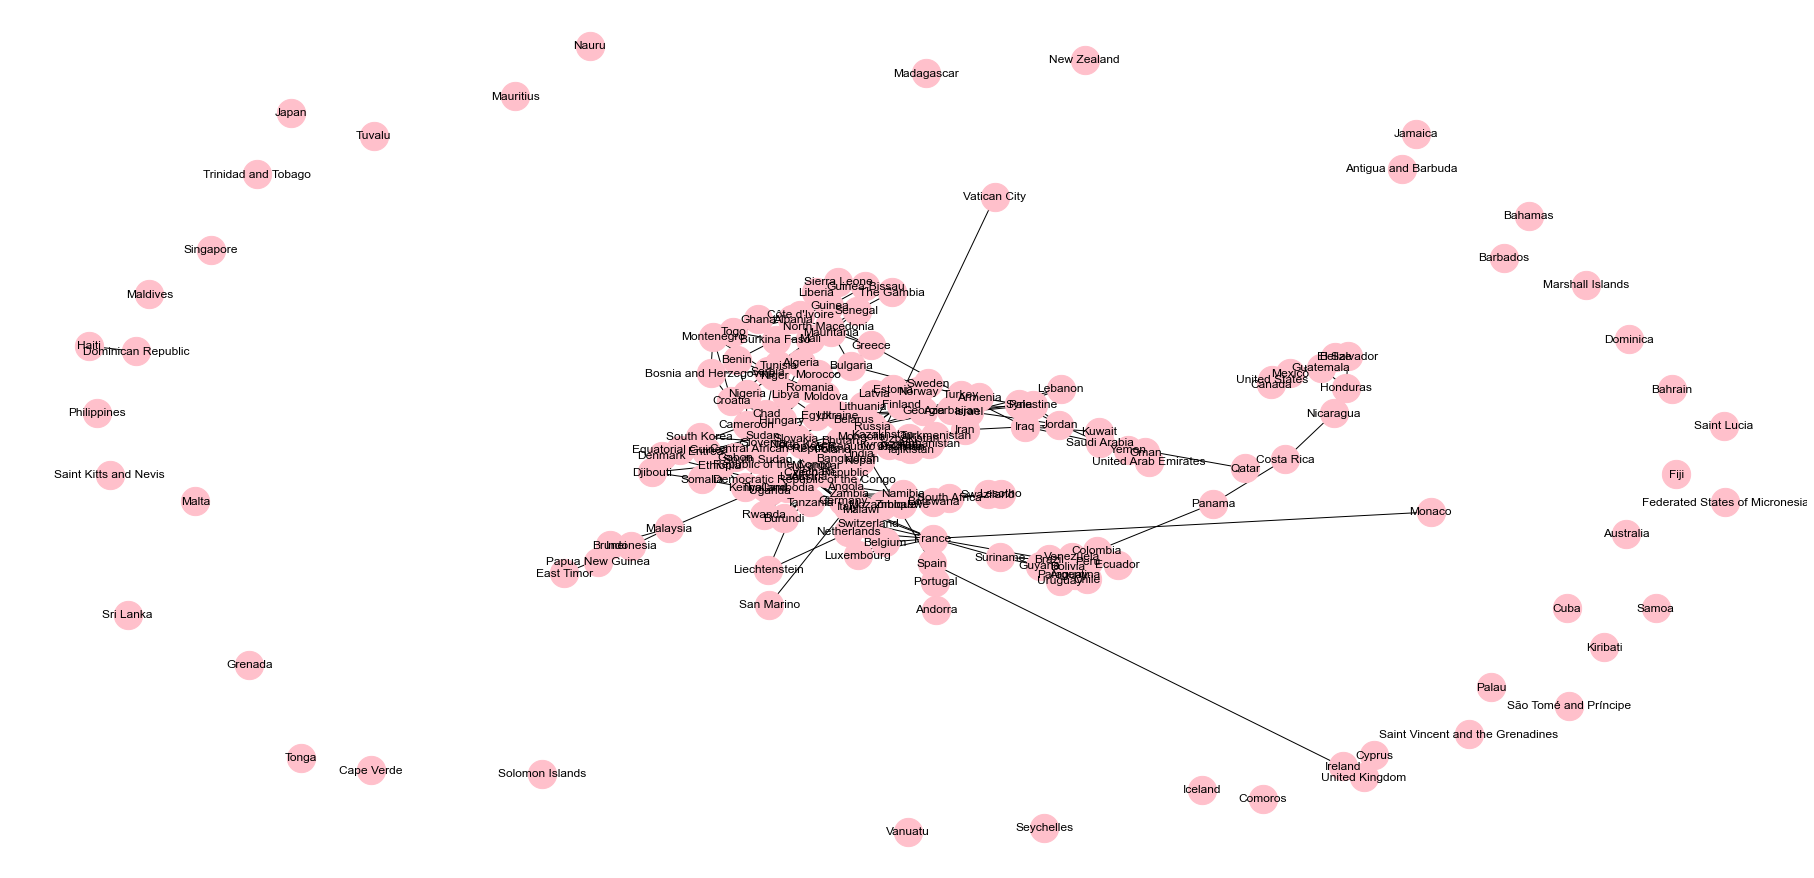

In [93]:
G = nx.Graph()
G.add_nodes_from([node['name'] for node in jdict['nodes']])
G.add_weighted_edges_from([(edge['source'], edge['target'], edge['border'])
                  for edge in jdict['links']])

pos = nx.spring_layout(G, k=.6)
plt.figure(figsize=(25,12))
nx.draw(G, 
        pos=pos,
        node_size=800, 
        with_labels=True, 
        node_color='pink')
plt.show()

### Transformando os nodes do grafo em valores numéricos (IDs)

In [94]:
class_values = sorted(df_test["Country"].unique())
print(len(class_values))
class_idx = {name: id for id, name in enumerate(class_values)}
df_test["Country ID"] = df_test["Country"].apply(lambda name: class_idx[name])
df_test.head().T


178


,0,1,2,5,7
Country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda
Population,7.49216,6.55408,7.51759,7.08376,4.83953
Area (sq. mi.),5.81124,4.45861,6.37689,6.09576,2.6464
Pop. Density (per sq. mi.),1.68124,2.09552,1.13988,0.986772,2.19312
Coastline (coast/area ratio),0,1.26,0.04,0.13,34.54
Net migration,23.06,-4.93,-0.39,0,-6.15
Infant mortality (per 1000 births),2.21237,1.33284,1.49136,2.28147,1.28914
GDP,2.8451,3.65321,3.77815,3.27875,4.04139
Literacy (%),6,9.30054,8.3666,6.48074,9.43398
Phones (per 1000),0.50515,1.85248,1.89265,0.892095,2.74028


In [95]:
df_edges["source"] = df_edges["source"].apply(lambda name: class_idx[name])
df_edges["target"] = df_edges["target"].apply(lambda name: class_idx[name])

In [96]:
df_edges.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
source,0,0,0,0,0,0,1,2,2,2,2,2,2,3,3,3,3,5,5,5
target,123,72,118,155,164,171,60,89,97,100,105,113,162,40,129,108,176,19,21,32


# Montando o classificador
Tutorial base: https://keras.io/examples/graph/gnn_citations/


In [97]:
feature_names = set(df_test.columns) - {"Country", "GDP", 'Country ID'}
num_features = len(feature_names)
num_classes = num_features
print(num_features, num_classes)

16 16


### Separando treino e teste

In [98]:
train_data, test_data = [], []

for _, group_data in df_test.groupby("GDP"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.7
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (122, 19)
Test data shape: (56, 19)


In [99]:
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()

y_train = train_data["GDP"]
y_test = test_data["GDP"]

In [100]:
x_train.shape

(122, 16)

### Testando o desempenho de modelos simples

In [101]:
def model_predict(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    train_pred_Y = model.predict(x_train)
    test_pred_Y = model.predict(x_test)
    train_pred_Y = pd.Series(train_pred_Y.clip(0, train_pred_Y.max()), index=y_train.index)
    test_pred_Y = pd.Series(test_pred_Y.clip(0, test_pred_Y.max()), index=y_test.index)


    rmse_train = np.sqrt(mean_squared_error(train_pred_Y, y_train))
    msle_train = mean_squared_log_error(train_pred_Y, y_train)
    rmse_test = np.sqrt(mean_squared_error(test_pred_Y, y_test))
    msle_test = mean_squared_log_error(test_pred_Y, y_test)

    print('rmse_train:',rmse_train,'msle_train:',msle_train)
    print('rmse_test:',rmse_test,'msle_test:',msle_test)

In [102]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [103]:
model = LinearRegression()
model_predict(model, x_train, y_train, x_test, y_test)

rmse_train: 0.16831277090710953 msle_train: 0.0014065627260584216
rmse_test: 0.21372688774190285 msle_test: 0.0022658521364282676


In [104]:
model = RandomForestRegressor(n_estimators = 50,
                             max_depth = 6,
                             min_weight_fraction_leaf = 0.05,
                             max_features = 0.8,
                             random_state = 42)

model_predict(model, x_train, y_train, x_test, y_test)

rmse_train: 0.1145281151302255 msle_train: 0.000659273668400273
rmse_test: 0.19741896890567878 msle_test: 0.0019196165920718222


In [105]:
feature_importances = (list(zip(model.feature_importances_,feature_names)))

In [106]:
model = DecisionTreeRegressor(max_depth = 6,
                             min_weight_fraction_leaf = 0.05,
                             max_features = 0.8,
                             random_state = 42)

model_predict(model, x_train, y_train, x_test, y_test)

rmse_train: 0.13171101258521803 msle_train: 0.0008593052233969853
rmse_test: 0.25701622099134686 msle_test: 0.00325695422331564


In [107]:
sorted(feature_importances, key=lambda x: x[0], reverse=True)

[(0.45869728207748733, 'Phones (per 1000)'),
 (0.24442727462364905, 'Infant mortality (per 1000 births)'),
 (0.15695118129062344, 'Agriculture'),
 (0.09760475868348963, 'Birthrate'),
 (0.009192745372710276, 'Net migration'),
 (0.005860232726552383, 'Industry'),
 (0.0057667382109257625, 'Crops (%)'),
 (0.004605728458664486, 'Pop. Density (per sq. mi.)'),
 (0.00415925079512669, 'Deathrate'),
 (0.0030577514691058584, 'Arable (%)'),
 (0.0026296556738827914, 'Other (%)'),
 (0.002286974668594599, 'Area (sq. mi.)'),
 (0.0015716339809235117, 'Literacy (%)'),
 (0.0011797887367997442, 'Coastline (coast/area ratio)'),
 (0.0010194330783189084, 'Population'),
 (0.0009895701531455628, 'Service')]

### Testando um modelo baseline 
Vamos primeiramente testar um modelo que ainda não leva em consideração as conexões do grafo. Ou seja, ele tenta prever o GDP apenas com a informação de cada país, desconsiderando suas fronteiras e as informações dos vizinhos.

In [108]:
##  Feedforward Network (FFN) Module
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [109]:

def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])

    outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x)

    return keras.Model(inputs=inputs, outputs=outputs, name="baseline")


baseline_model = create_baseline_model( [32, 32], num_classes,  0.5)
baseline_model.summary()


Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 16)]         0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           1792        ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

In [110]:
def run_experiment(model, x_train, y_train):
    model.compile(
        optimizer=keras.optimizers.Adam(1e-1),
        loss='mse',
    )
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="loss", patience=50, restore_best_weights=True
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=5000,
        batch_size=2048,
        validation_split=0.2,
        callbacks=[early_stopping],

    )

    return history

In [111]:
def display_learning_curves(history):
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    plt.show()

In [112]:
history_baseline = run_experiment(baseline_model, x_train, y_train)

Epoch 1/5000
1/1 [==============================] - 4s 4s/step - loss: 12.2807 - val_loss: 12.5021
Epoch 2/5000
1/1 [==============================] - 0s 30ms/step - loss: 12.3138 - val_loss: 12.5021
Epoch 3/5000
1/1 [==============================] - 0s 31ms/step - loss: 12.3126 - val_loss: 12.5021
Epoch 4/5000
1/1 [==============================] - 0s 31ms/step - loss: 12.3471 - val_loss: 12.5021
Epoch 5/5000
1/1 [==============================] - 0s 32ms/step - loss: 12.3435 - val_loss: 12.5021
Epoch 6/5000
1/1 [==============================] - 0s 32ms/step - loss: 12.3304 - val_loss: 12.5021
Epoch 7/5000
1/1 [==============================] - 0s 32ms/step - loss: 12.3352 - val_loss: 12.5021
Epoch 8/5000
1/1 [==============================] - 0s 32ms/step - loss: 12.3311 - val_loss: 12.5021
Epoch 9/5000
1/1 [==============================] - 0s 32ms/step - loss: 12.3417 - val_loss: 12.5021
Epoch 10/5000
1/1 [==============================] - 0s 31ms/step - loss: 12.3372 - val_loss:

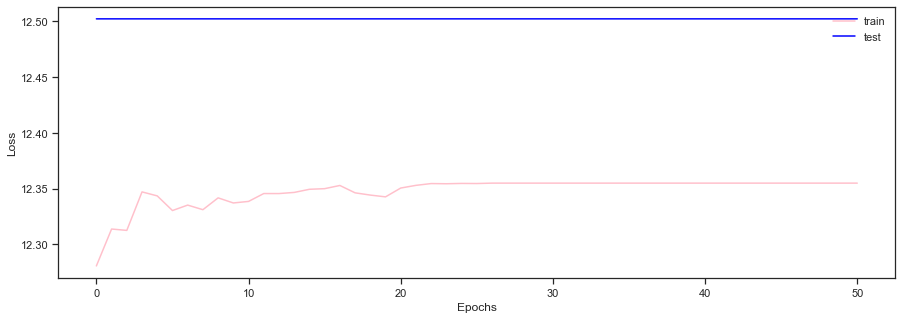

In [113]:
display_learning_curves(history_baseline)

In [114]:
original_mse = np.sqrt(baseline_model.evaluate(x=x_test, y=y_test, verbose=0))

In [115]:
original_mse

3.5277825269558662

In [116]:
list(zip(baseline_model(x_test).numpy()[:,0], y_test))

[(5.6998572e-21, 4.02530586526477),
 (3.0261946e-18, 3.9444826721501687),
 (1.1968798e-15, 4.4281347940287885),
 (3.717167e-22, 3.255272505103306),
 (4.1301094e-16, 4.269512944217916),
 (8.6485514e-20, 4.463892988985907),
 (4.7869505e-18, 3.342422680822206),
 (2.651035e-20, 3.230448921378274),
 (4.313778e-24, 4.741151598851785),
 (1.954435e-15, 4.107209969647869),
 (3.2456917e-18, 3.7634279935629373),
 (1.1833954e-16, 3.7075701760979363),
 (1.1183098e-26, 2.9030899869919438),
 (1.0018737e-17, 3.2041199826559246),
 (2.9828958e-13, 4.222716471147583),
 (2.9715377e-25, 3.322219294733919),
 (1.9412272e-34, 2.7781512503836434),
 (0.0, 3.278753600952829),
 (2.4936714e-25, 3.8260748027008264),
 (1.1914468e-20, 3.462397997898956),
 (6.5840593e-22, 4.3979400086720375),
 (9.73888e-24, 2.9030899869919438),
 (5.4908807e-19, 3.690196080028514),
 (7.802135e-23, 3.7781512503836434),
 (0.0, 4.492760389026838),
 (5.785565e-25, 4.332438459915605),
 (2.829801e-16, 3.681241237375587),
 (1.4545467e-16, 3.5

### Modelo GNN - que considera os grafos

Vamos agora incorporar as informações dos vizinhos na previsão do nosso modelo

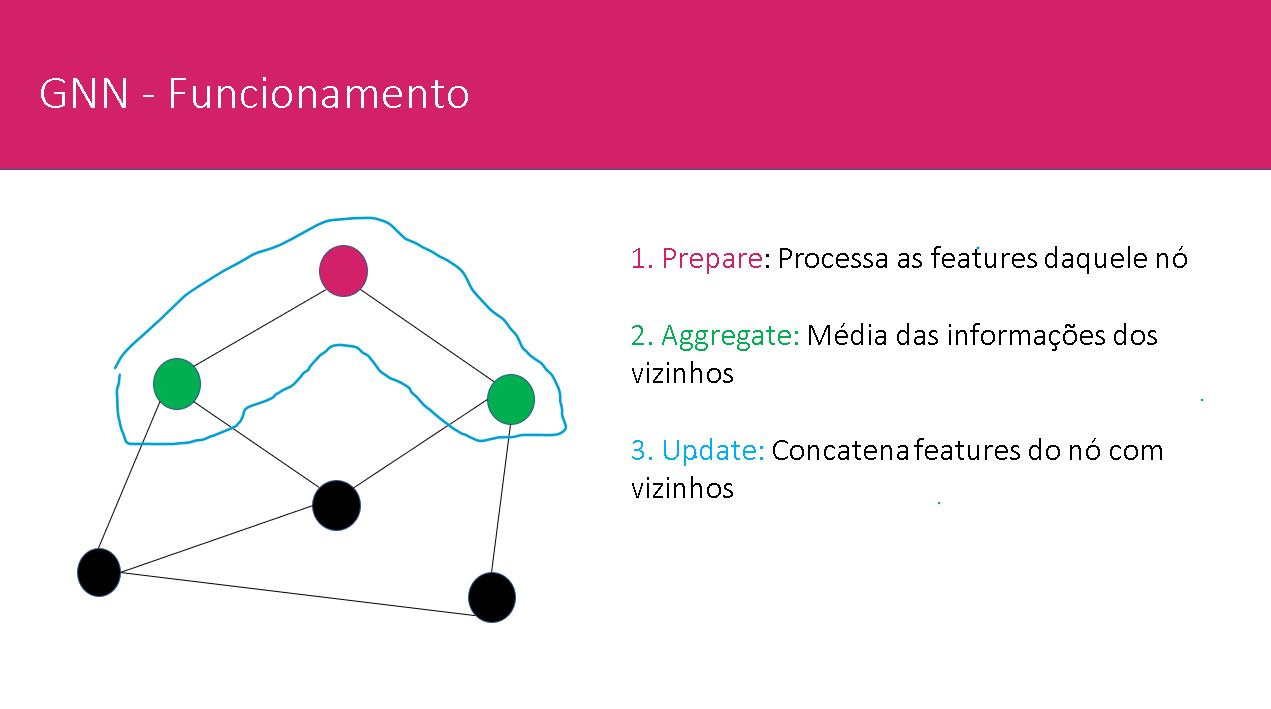

In [117]:
DROPOUT_RATE  =0.2

In [118]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=DROPOUT_RATE,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        messages = self.ffn_prepare(node_repesentations)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        num_nodes = node_repesentations.shape[0]
        aggregated_message = tf.math.unsorted_segment_mean(
            neighbour_messages, node_indices, num_segments=num_nodes
        )
        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        node_embeddings = self.update_fn(h)
        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        node_repesentations, edges, edge_weights = inputs
        node_indices, neighbour_indices = edges[0], edges[1]
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        return self.update(node_repesentations, aggregated_messages)


In [119]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=DROPOUT_RATE,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights

        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])

        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")

        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )

        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        x = self.preprocess(self.node_features)
        x1 = self.conv1((x, self.edges, self.edge_weights))
        x = x1 + x
        x2 = self.conv2((x, self.edges, self.edge_weights))
        x = x2 + x
        x = self.postprocess(x)
        node_embeddings = tf.gather(x, input_node_indices)
        return self.compute_logits(node_embeddings)


#### Preparação dos dados

In [120]:
edges = df_edges[["source", "target"]].to_numpy().T
edge_weights = tf.ones(shape=edges.shape[1])
node_features = tf.cast(
    df_test.sort_values("Country")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)

In [121]:
graph_info = (node_features, edges, edge_weights)
print("Node features shape:", node_features.shape)
print("Edges shape:", edges.shape)
print("edge_weights shape:", edge_weights.shape)

Node features shape: (178, 16)
Edges shape: (2, 281)
edge_weights shape: (281,)


#### Instanciando o modelo

In [122]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=[32, 32],
    dropout_rate=DROPOUT_RATE,
    name="gnn_model",
)


In [123]:
gnn_model([1,10])

<tf.Tensor: shape=(2, 16), dtype=float32, numpy=
array([[ 1.3223174 , -2.4334085 ,  0.87172437,  0.33391243, -0.54370105,
         1.0632639 , -1.0031521 , -2.9664187 , -1.1058257 ,  0.98948765,
        -0.21145868,  1.8251381 ,  2.925853  ,  0.8904027 , -0.45962954,
         0.27605247],
       [-0.03981708, -1.825892  ,  0.532796  ,  0.67470264, -0.79872197,
         1.8872912 , -0.9146868 , -3.847629  , -1.7951587 ,  0.28071263,
        -0.41922754,  2.4898236 ,  2.5586662 ,  0.5887773 , -0.8478983 ,
         0.24140501]], dtype=float32)>

In [124]:
gnn_model.summary()

Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (178, 32)                 1792      
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 postprocess (Sequential)    (178, 32)                 2368      
                                                                 
 logits (Dense)              multiple                  528       
                                                                 
Total params: 16,464
Trainable params: 15,600
Non-trainab

In [125]:
x_train = train_data['Country ID'].to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/5000
1/1 [==============================] - 3s 3s/step - loss: 14.1285 - val_loss: 6.9625
Epoch 2/5000
1/1 [==============================] - 0s 30ms/step - loss: 5.9131 - val_loss: 389.9228
Epoch 3/5000
1/1 [==============================] - 0s 23ms/step - loss: 7.3674 - val_loss: 1199.0090
Epoch 4/5000
1/1 [==============================] - 0s 29ms/step - loss: 3.2415 - val_loss: 541.9597
Epoch 5/5000
1/1 [==============================] - 0s 30ms/step - loss: 1.9487 - val_loss: 957.0831
Epoch 6/5000
1/1 [==============================] - 0s 25ms/step - loss: 2.3061 - val_loss: 2488.3938
Epoch 7/5000
1/1 [==============================] - 0s 32ms/step - loss: 1.9484 - val_loss: 2125.3208
Epoch 8/5000
1/1 [==============================] - 0s 31ms/step - loss: 1.8284 - val_loss: 1053.5452
Epoch 9/5000
1/1 [==============================] - 0s 31ms/step - loss: 1.6393 - val_loss: 537.9519
Epoch 10/5000
1/1 [==============================] - 0s 32ms/step - loss: 1.1534 - val_los

### Análise de Desempenho

In [126]:
def display_learning_curves(history):
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

    ax1.plot(history.history["loss"][70:])
    ax1.plot(history.history["val_loss"][70:])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    plt.show()

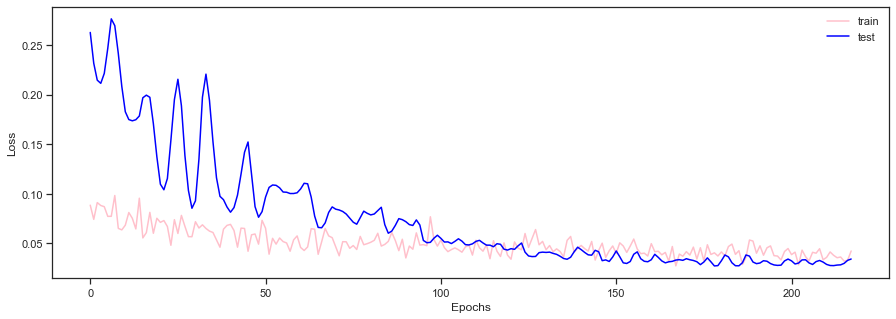

In [127]:
display_learning_curves(history)

In [128]:
x_test = test_data['Country ID'].to_numpy()

#### Performance no treino

In [129]:
mse_train = gnn_model.evaluate(x=x_train, y=y_train, verbose=0)
print(np.sqrt(mse_train))


0.17769328889598127


#### Performance no teste

In [130]:
mse_test = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(np.sqrt(mse_test))

0.21555930532829462


#### Melhora comparado ao baseline model

In [131]:
original_mse/np.sqrt(mse_test)

16.365716718111933

#### Lista de previsões individuais

In [132]:
list(zip(x_train, gnn_model(x_train).numpy()[:,0], y_train))

[(23, 3.8567195, 3.8808135922807914),
 (8, 4.2629724, 4.477121254719663),
 (26, 3.1316056, 3.278753600952829),
 (64, 2.9781032, 2.9030899869919438),
 (116, 4.293899, 4.577491799837225),
 (39, 3.0773373, 3.146128035678238),
 (28, 4.3121133, 4.474216264076255),
 (78, 4.258622, 4.450249108319361),
 (174, 3.5188303, 3.3979400086720375),
 (127, 4.115231, 4.2552725051033065),
 (107, 3.2158437, 3.255272505103306),
 (122, 3.4972038, 3.6720978579357175),
 (79, 3.9189115, 3.6334684555795866),
 (45, 3.469246, 3.5185139398778875),
 (16, 3.645125, 3.690196080028514),
 (84, 3.0767498, 3.230448921378274),
 (110, 4.251633, 4.456366033129043),
 (166, 3.7412848, 3.7323937598229686),
 (46, 3.4255028, 3.6020599913279625),
 (146, 4.056083, 4.342422680822207),
 (114, 3.046627, 2.9542425094393248),
 (69, 4.3029876, 4.489958479424835),
 (136, 3.5007563, 3.7481880270062002),
 (68, 4.041156, 4.143014800254095),
 (117, 3.7170181, 4.117271295655764),
 (145, 4.206863, 4.250420002308894),
 (161, 3.71951, 3.97772360

In [133]:
list(zip(x_train, gnn_model(x_train).numpy()[:,0], y_train))

[(23, 3.8567195, 3.8808135922807914),
 (8, 4.2629724, 4.477121254719663),
 (26, 3.1316056, 3.278753600952829),
 (64, 2.9781032, 2.9030899869919438),
 (116, 4.293899, 4.577491799837225),
 (39, 3.0773373, 3.146128035678238),
 (28, 4.3121133, 4.474216264076255),
 (78, 4.258622, 4.450249108319361),
 (174, 3.5188303, 3.3979400086720375),
 (127, 4.115231, 4.2552725051033065),
 (107, 3.2158437, 3.255272505103306),
 (122, 3.4972038, 3.6720978579357175),
 (79, 3.9189115, 3.6334684555795866),
 (45, 3.469246, 3.5185139398778875),
 (16, 3.645125, 3.690196080028514),
 (84, 3.0767498, 3.230448921378274),
 (110, 4.251633, 4.456366033129043),
 (166, 3.7412848, 3.7323937598229686),
 (46, 3.4255028, 3.6020599913279625),
 (146, 4.056083, 4.342422680822207),
 (114, 3.046627, 2.9542425094393248),
 (69, 4.3029876, 4.489958479424835),
 (136, 3.5007563, 3.7481880270062002),
 (68, 4.041156, 4.143014800254095),
 (117, 3.7170181, 4.117271295655764),
 (145, 4.206863, 4.250420002308894),
 (161, 3.71951, 3.97772360

In [134]:
list(zip(gnn_model(x_train).numpy()[:,0], y_train))

[(3.8567195, 3.8808135922807914),
 (4.2629724, 4.477121254719663),
 (3.1316056, 3.278753600952829),
 (2.9781032, 2.9030899869919438),
 (4.293899, 4.577491799837225),
 (3.0773373, 3.146128035678238),
 (4.3121133, 4.474216264076255),
 (4.258622, 4.450249108319361),
 (3.5188303, 3.3979400086720375),
 (4.115231, 4.2552725051033065),
 (3.2158437, 3.255272505103306),
 (3.4972038, 3.6720978579357175),
 (3.9189115, 3.6334684555795866),
 (3.469246, 3.5185139398778875),
 (3.645125, 3.690196080028514),
 (3.0767498, 3.230448921378274),
 (4.251633, 4.456366033129043),
 (3.7412848, 3.7323937598229686),
 (3.4255028, 3.6020599913279625),
 (4.056083, 4.342422680822207),
 (3.046627, 2.9542425094393248),
 (4.3029876, 4.489958479424835),
 (3.5007563, 3.7481880270062002),
 (4.041156, 4.143014800254095),
 (3.7170181, 4.117271295655764),
 (4.206863, 4.250420002308894),
 (3.71951, 3.9777236052888476),
 (3.2013445, 3.2041199826559246),
 (4.2389235, 4.440909082065217),
 (4.127021, 4.365487984890899),
 (4.227049

Parece que este modelo ficou bem melhor! Os valores preditos são bem próximos dos reais